In [1]:
using Revise, HarmonicBalance

  Activating project at `~/.julia/environments/v1.7`
┌ Info: Precompiling HarmonicBalance [e13b9ff6-59c3-11ec-14b1-f3d2cc6c135e]
└ @ Base loading.jl:1423


# Define the differential equation of motion

In [2]:
@variables γ, F, α, ω0, F0, η, J, ω, t, Δω, x(t), y(t);

In [3]:
# a vector of expressions - these must equal to zero
diff_eq = DifferentialEquation([d(x,t,2) + γ * d(x,t) + ω0^2 * x + α*x^3+ 2*J*ω0*(x-y) - F0*cos(ω*t), 
            d(y,t,2) + γ * d(y,t) + ω0^2 * y + α*y^3 + 2*J*ω0*(y-x) - η*F0*cos(ω*t)], [x,y])

# describe each variable using one or more Fourier components
add_harmonic!(diff_eq, x, ω)
add_harmonic!(diff_eq, y, ω)
add_Hopf!(diff_eq, Δω)
harmonic_eq = get_harmonic_equations(diff_eq);

# Hopf manipulation

In [4]:
# remove one Hopf variable, replace by Δω
prob = HarmonicBalance.Hopf._Hopf_Problem(harmonic_eq, Δω);

# show the current variables
#get_variables(harmonic_eq)

In [5]:
prob.system

System of length 12
 12 variables: u1, v1, u2, v2, u3, v3, u4, v4, u5, v5, u6, Δω
 7 parameters: α, ω, ω0, γ, F0, J, η

 -F0 - u1*ω^2 + u1*ω0^2 + (3/4)*u1^3*α + 2*J*u1*ω0 - 2*J*u4*ω0 + (3/4)*u1*v1^2*α + (3/2)*u1*v2^2*α + (3/2)*u1*v3^2*α + (3/2)*u2^2*u1*α + (3/2)*u3^2*u1*α + v1*γ*ω + (-3/2)*u1*v3*v2*α + (3/2)*u2*u3*u1*α + (3/2)*u2*v3*v1*α + (3/2)*u3*v2*v1*α
 -v1*ω^2 + v1*ω0^2 + (3/4)*v1^3*α + 2*J*v1*ω0 - 2*J*v4*ω0 - u1*γ*ω + (3/4)*u1^2*v1*α + (3/2)*u2^2*v1*α + (3/2)*u3^2*v1*α + (3/2)*v2^2*v1*α + (3/2)*v3^2*v1*α + (3/2)*u2*u1*v3*α + (-3/2)*u2*u3*v1*α + (3/2)*u3*u1*v2*α + (3/2)*v3*v2*v1*α
 -u2*Δω^2 - u2*ω^2 + u2*ω0^2 + (3/4)*u2^3*α + 2*J*u2*ω0 - 2*J*u5*ω0 + (3/2)*u2*u1^2*α + (3/2)*u2*u3^2*α + (3/2)*u2*v1^2*α + (3/4)*u2*v2^2*α + (3/2)*u2*v3^2*α - 2*u2*ω*Δω + (3/4)*u3*u1^2*α + (-3/4)*u3*v1^2*α + v2*γ*Δω + v2*γ*ω + (3/2)*u1*v3*v1*α
 -v2*Δω^2 - v2*ω^2 + v2*ω0^2 + (3/4)*v2^3*α + 2*J*v2*ω0 - 2*J*v5*ω0 + (3/2)*u1^2*v2*α + (-3/4)*u1^2*v3*α - u2*γ*Δω - u2*γ*ω + (3/4)*u2^2*v2*α + (3/2)*u3^2*v2*α + 

# Solving the resulting polynomial equations

In [6]:
fixed_parameters = (
    ω0 => 1.4504859, # natural frequency of separate modes (in paper, ħω0 - J)
    γ => 27.4E-6,    # damping
    J => 154.1E-6,   # coupling term
    α => 3.867E-7,   # Kerr nonlinearity
    ω => 1.4507941,  # pump frequency, resonant with antisymmetric mode (in paper, ħω0 + J)
    η => -0.08,      # pumping leaking to site 2  (F2 = ηF1)
    F0 => 0.011       # pump amplitude (overriden in sweeps)
)

pars_Titta = [Dict(fixed_parameters)[p] for p in prob.parameters]

7-element Vector{Float64}:
  3.867e-7
  1.4507941
  1.4504859
  2.74e-5
  0.011
  0.0001541
 -0.08

In [7]:
@doc HarmonicBalance.HomotopyContinuation.newton

```
newton(
    F::AbstractSystem,
    x₀::AbstractVector,
    p = nothing,
    norm::AbstractNorm = InfNorm(),
    cache::NewtonCache = NewtonCache(F);
    options...
)
```

An implemenetation of a local Newton's method with various options to specify convergence criteria. Returns a [`NewtonResult`](@ref). The computations are always performed in complex arithmetic with double precision, i.e., using `Complex{Float64}`. The optional `cache` argument pre-allocates the necessary memory. This is useful if the method is called repeatedly.

### Options

  * `atol::Float64 = 1e-8`: The method is declared converged if `norm(xᵢ₊₁ - xᵢ) < atol`.
  * `rtol::Float64 = atol`: The method is declared converged if `norm(xᵢ₊₁ - xᵢ) < max(atol, rtol * norm(x₀))`.
  * `max_iters::Int = 20`: The maximal number of iterations.
  * `extended_precision::Bool = false`: An optional use of extended precision for the evaluation of `F(x)`. This can increase the achievable accuracy.
  * `contraction_factor::Float64 = 1.0`: The Newton updates have to satisfy $|xᵢ₊₁ - xᵢ| < a^{2^{i-1}}|x₁ - x₀|$ for $i ≥ 1$ where $a$ is `contraction_factor`.
  * `min_contraction_iters::Int = typemax(Int)`:  The minimal number of iterations the `contraction_factor` has to be satisfied. If after `min_contraction_iters` many iterations the contraction factor is not satisfied the step is accepted anyway.
  * `max_abs_norm_first_update::Float64 = Inf`: The initial guess `x₀` is rejected if `norm(x₁ - x₀) >  max_abs_norm_first_update`
  * `max_rel_norm_first_update::Float64 = max_abs_norm_first_update`: The initial guess `x₀` is rejected if `norm(x₁ - x₀) >  max_rel_norm_first_update * norm(x₀)`


In [8]:
using LinearAlgebra


res = HarmonicBalance.HomotopyContinuation.newton(prob.system, cat(-randn(11), 0.0, dims=1), pars_Titta, max_iters=300)
while res.return_code == :rejected
    res = HarmonicBalance.HomotopyContinuation.newton(prob.system, 10*cat(randn(11), zeros(1), dims=1), pars_Titta, max_iters=300)
end

norm(res.x).^2

1268.2588588343335

In [9]:
res.x

12-element Vector{ComplexF64}:
     10.102043417418502 + 0.0im
      4.201292024237808 + 0.0im
 -8.433758354584419e-81 + 0.0im
 2.1084395886461046e-80 + 0.0im
 1.2650637531876628e-80 + 0.0im
  4.216879177292209e-80 + 0.0im
     -33.55240101074065 + 0.0im
     -4.774212956573529 + 0.0im
 2.5301275063753256e-80 + 0.0im
 -5.060255012750651e-80 + 0.0im
  5.271098971615262e-81 + 0.0im
 0.00011719984948995447 + 0.0im

In [ ]:
range = F0 => LinRange(0.002, 0.025, 100)

solutions = get_steady_states(prob, range, fixed_parameters, random_warmup=true)

Tracking 469066 paths...  66%|█████████████████▎        |  ETA: 1:08:01
  # paths tracked:                  311200
  # non-singular solutions (real):  975 (0)
  # singular endpoints (real):      42 (0)
  # total solutions (real):         1017 (0)

In [192]:
solutions[3][1]

OrderedCollections.OrderedDict{Symbolics.Num, ComplexF64} with 19 entries:
  u1 => -14.1006+6.46992e-35im
  v1 => 3.73439-2.18172e-35im
  u2 => -6.65268+1.92593e-34im
  v2 => -3.26508+8.87733e-35im
  u3 => -4.37583+1.56482e-34im
  v3 => 0.614236-2.70834e-35im
  u4 => -45.3161-6.01853e-36im
  v4 => -1.94252+1.80556e-35im
  u5 => -5.56459+2.16667e-34im
  v5 => -1.4936+4.43867e-35im
  u6 => 8.28031-3.37038e-34im
  Δω => -0.000211206-4.1326e-40im
  F0 => 0.025+0.0im
  ω0 => 1.45049+0.0im
  γ  => 2.74e-5+0.0im
  J  => 0.0001541+0.0im
  α  => 3.867e-7+0.0im
  ω  => 1.45079+0.0im
  η  => -0.08+0.0im

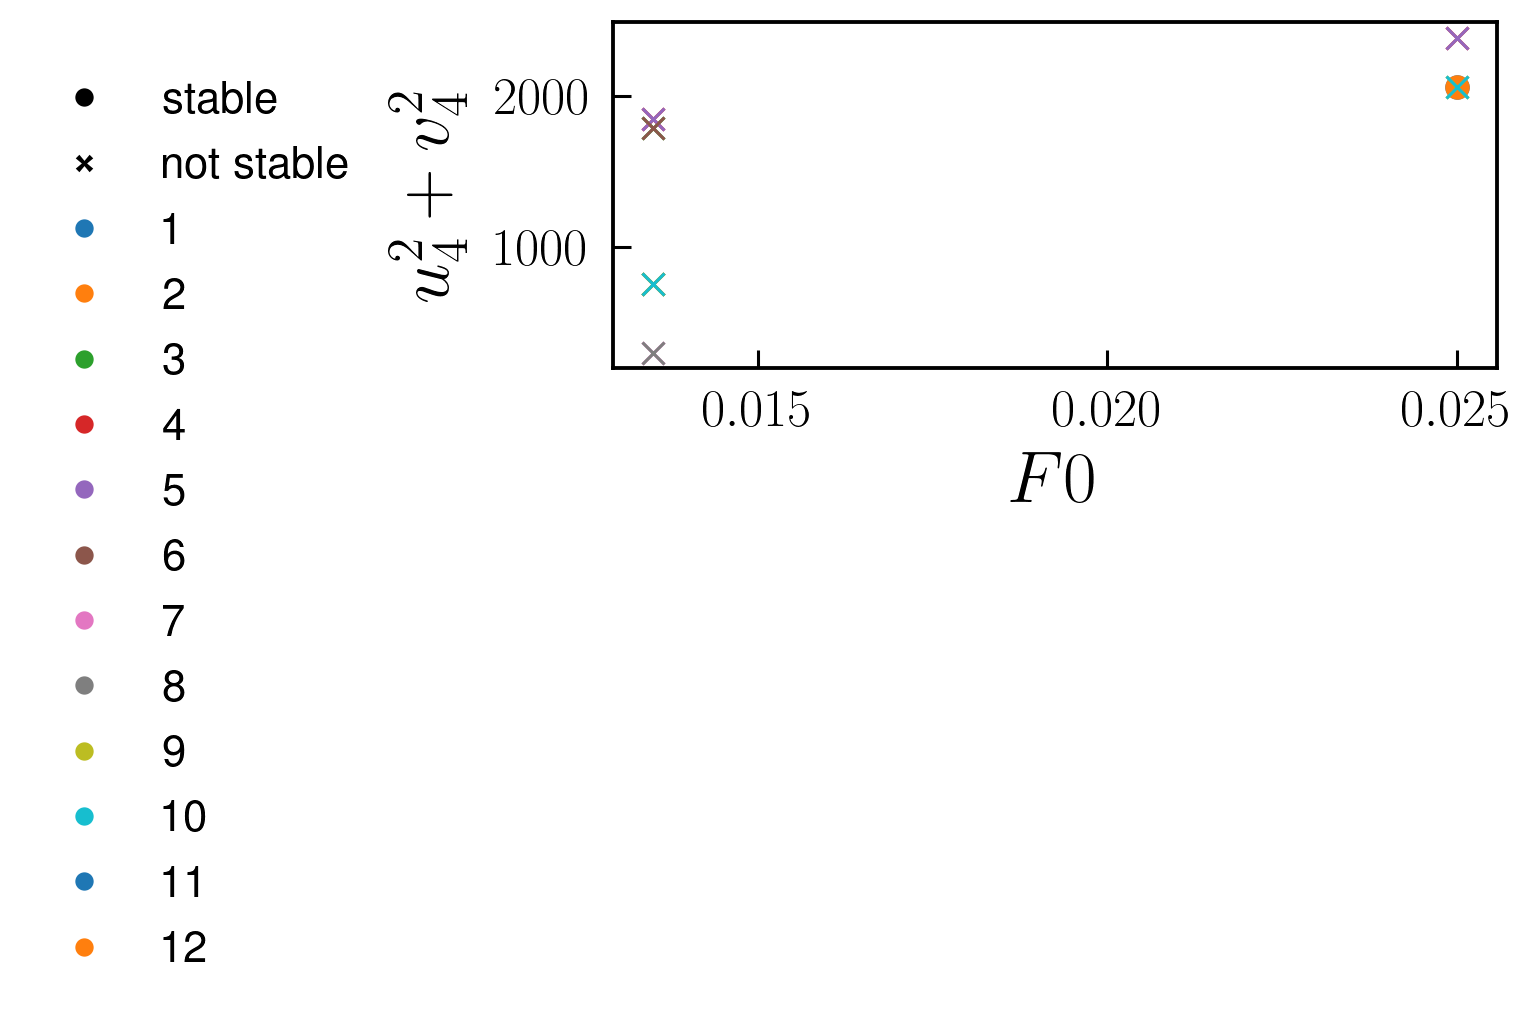

In [190]:
plt = plot_1D_solutions(solutions, x="F0", y="u4^2 + v4^2");
#HarmonicBalance.savefig("asym.png")

In [6]:
import HarmonicBalance.TimeEvolution: ODEProblem, DifferentialEquations.solve, ParameterSweep
initial_state = solutions[1][1]

T = 2E6
sweep = ParameterSweep(F0 => (0.002, 0.011), (0,T))
TDproblem = ODEProblem(harmonic_eq, initial_state, sweep=sweep, timespan=(0,2*T))
TDsoln = solve(TDproblem, saveat=1);

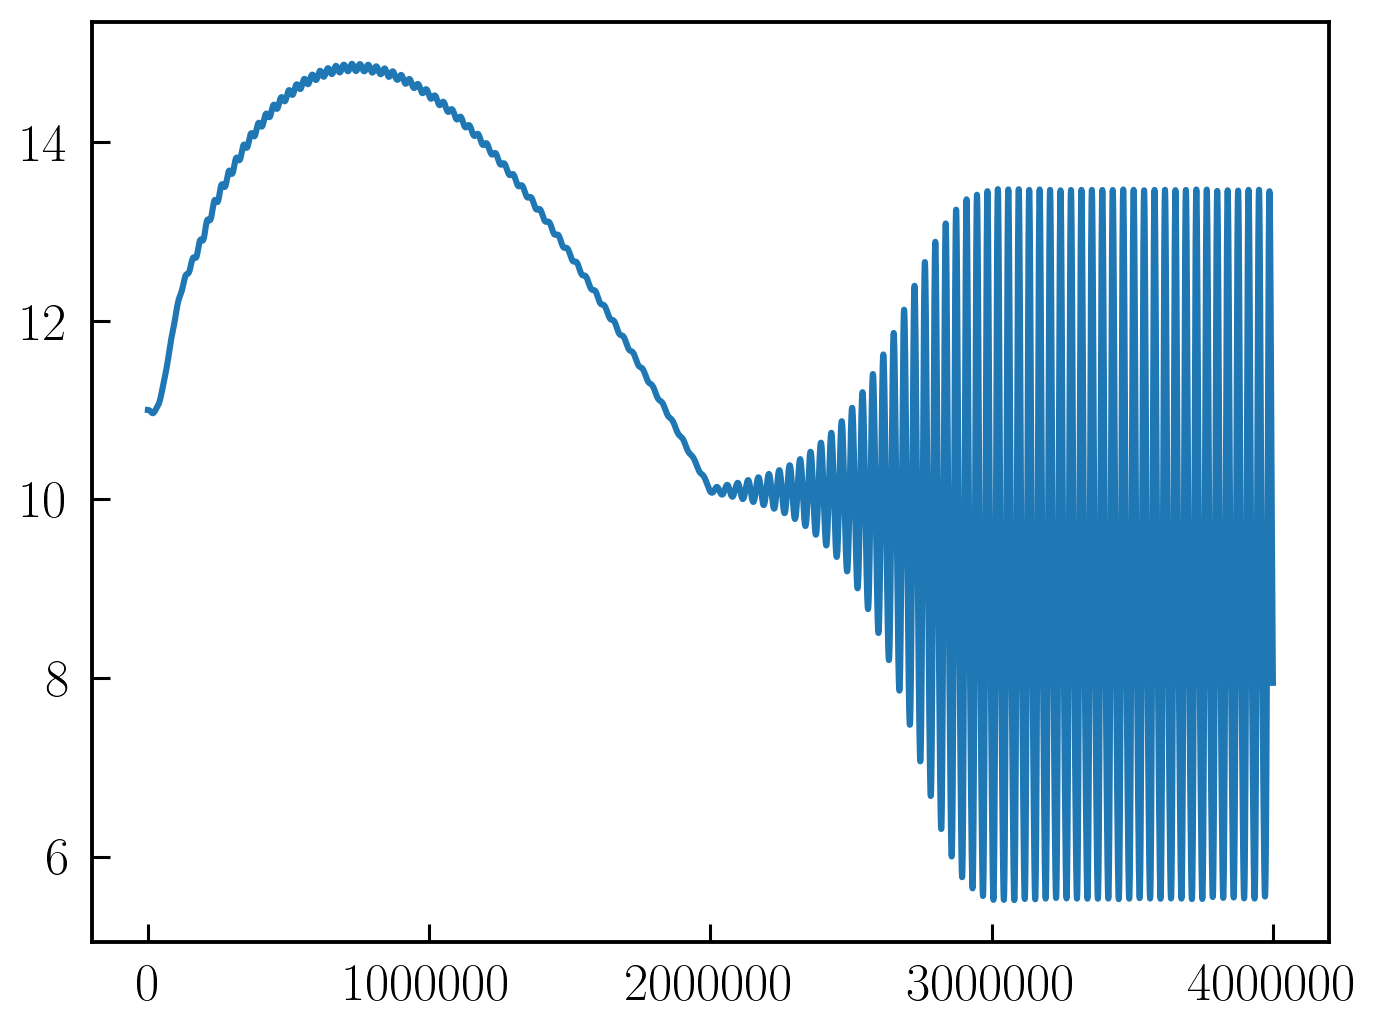

In [11]:
plot(TDsoln.t, getindex.(TDsoln.u, 1));
#HarmonicBalance.xlabel("time", fontsize=24)
#HarmonicBalance.ylabel(HarmonicBalance.latexify("u_1"), fontsize=24)

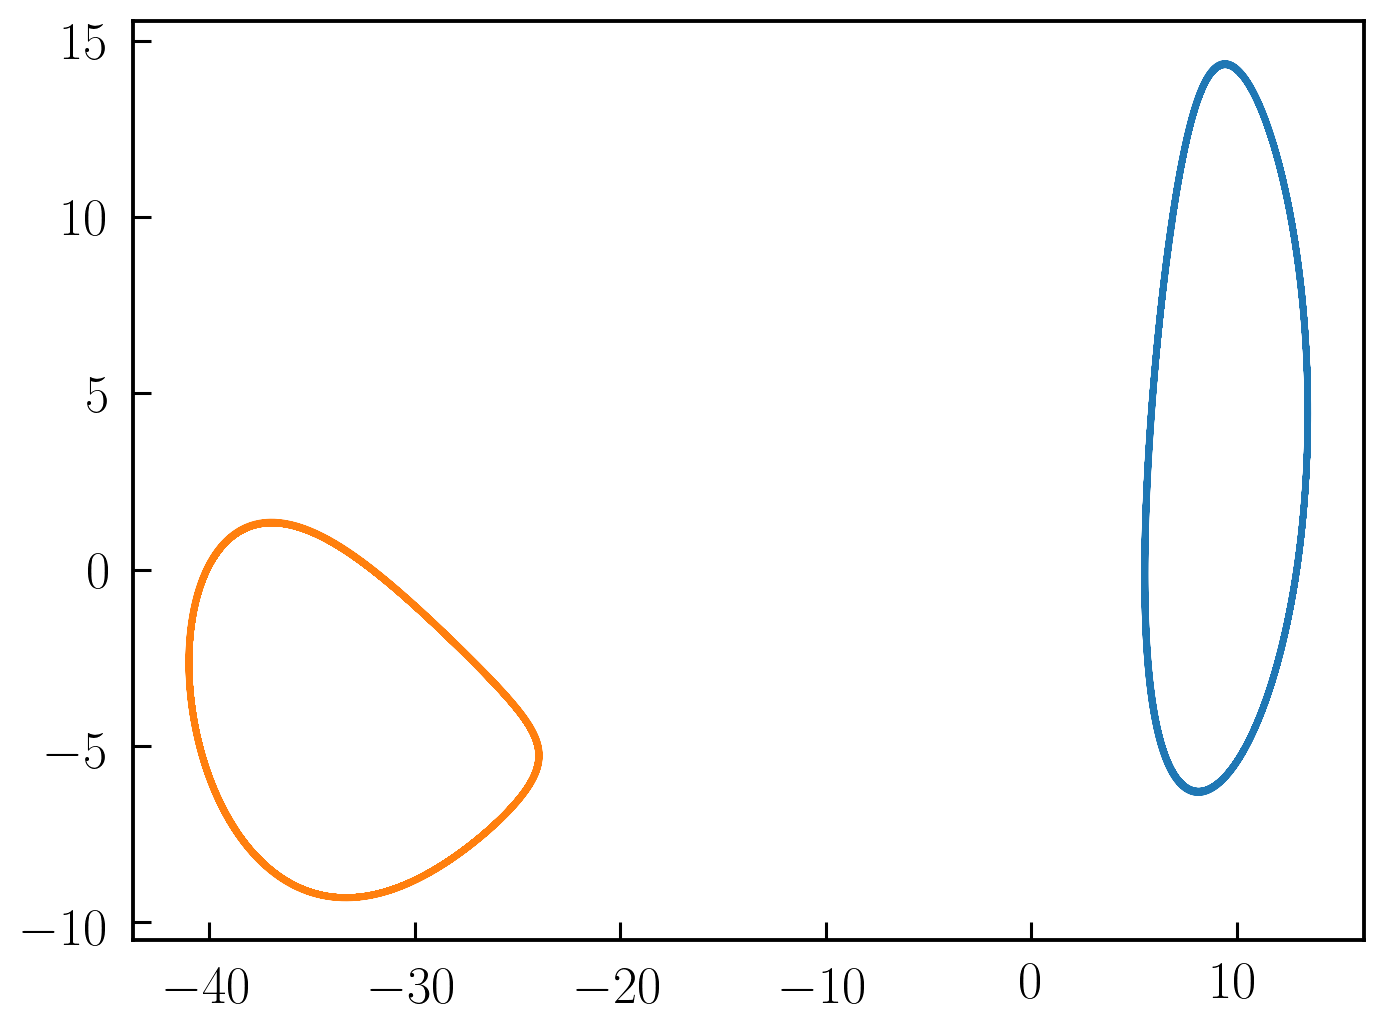

In [10]:
u(i) = getindex.(TDsoln.u, i)[Int(1.5*T):end]
plot(u(1), u(2))
plot(u(3), u(4));
#HarmonicBalance.xlabel(HarmonicBalance.latexify("u_1, u_2"), fontsize=24)
#HarmonicBalance.ylabel(HarmonicBalance.latexify("v_1, v_2"), fontsize=24)